## bt 패키지
### bt 패키지에서는 백테스트의 과정을 다음과 같이 정의한다.

- 데이터의 수집
- 전략의 정의
- 데이터를 이용한 전략의 백테스트
- 결과에 대한 평가
- 데이터의 수집
- 백테스트를 위해서는 먼저 데이터를 준비해야 한다. bt 패키지의 get() 함수는 야후 파이낸스 API를 이용해 수정주가를 다운로드 받을 수 있게 해준다. 물론 기존의 Pandas-datareader 패키지나 크롤링을 통해 데이터를 수집할 수도 있다.

In [1]:
import bt

In [2]:
data = bt.get("SPY, QQQ, SOXL, TLT", start='2020-01-01')
data.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,spy,qqq,soxl,tlt
Date,,,,
2023-06-26,431.440002,357.679993,22.090000,103.440002
2023-06-27,436.170013,363.829987,24.370001,103.169998
2023-06-28,436.390015,364.540009,23.719999,103.610001
2023-06-29,438.109985,363.809998,23.809999,101.739998
2023-06-30,443.279999,369.420013,24.830000,102.940002


### 전략의 정의
- 두번째로 시뮬레이션 하고자 하는 백테스트가 어떤 것인지를 정의해야 한다. 10개 자산을 동일비중으로 투자하며, 매월 말 리밸런싱 하는 전략을 정의해보도록 하겠다. Strategy() 함수 내에 algos 모듈을 이용해 백테스트 하고자 하는 내용을 입력한다.

## 매월 말 리밸런싱 전략
- 동일비중

In [3]:
import bt

# 전체 자산 동일비중, 매월 말 리밸런싱
strategy = bt.Strategy("Asset_EW", [
    bt.algos.SelectAll(),
    bt.algos.WeighEqually(),
    bt.algos.RunMonthly(),
    bt.algos.Rebalance()
])

### 먼저 전략의 이름(Asset_EW)을 입력한다.
1. bt.algos.SelectAll() 함수를 통해 모든 데이터를 사용함을 정의한다.
2. bt.algos.WeighEqually() 함수를 통해 동일비중으로 투자할 것을 정의한다.
3. bt.algos.RunMonthly() 함수를 통해 매월말 리밸런싱 함을 정의한다.
4. bt.algos.Rebalance() 함수를 통해 계산된 비중에 따라 리밸런싱 함을 정의한다.
이 외에 algos 모듈을 통해 다양한 백테스트 로직을 정의할 수 있으며, 자세한 내용은 아래 사이트에서 확인할 수 있다.

- https://pmorissette.github.io/bt/bt.html#module-bt.algos

### 전략의 백테스트
앞에서 정의된 내용을 바탕으로 백테스트를 실행한다.

1. 가격 데이터 중 ETF의 시작 시점이 모두 다르므로, dropna() 함수를 통해 NA를 모두 제거하여 시작시점을 동일하게 만든다.
2. Backtest() 함수를 통해 백테스트를 생성할 수 있으며, 앞에서 정의한 백테스트 정의(strategy)와 가격 데이터(data)를 입력한다.
3. run() 함수를 통해 백테스트를 실행하며, 앞에서 생성된 백테스트(backtest)를 입력한다.

In [13]:
data_bt = data.dropna()

# 백테스트 생성
backtest = bt.Backtest(strategy, data_bt)

# 백테스트 실행
result = bt.run(backtest)

In [14]:
result.prices
# 백테스트 결과에서 prices를 입력하면 누적수익률이 데이터프레임 형태로 나타나며, 시작시점을 100으로 환산하여 계산된다.

,Asset_EW
2020-01-01,100.000000
2020-01-02,100.000000
2020-01-03,98.616540
2020-01-06,97.976446
2020-01-07,98.959696
...,...
2023-06-26,167.882739
2023-06-27,173.242782
2023-06-28,172.306258
2023-06-29,171.806183


In [15]:
result.prices.to_returns() # prices에 추가로 to_returns()를 입력하면, 수익률이 계산된다.

,Asset_EW
2020-01-01,NaN
2020-01-02,0.000000
2020-01-03,-0.013835
2020-01-06,-0.006491
2020-01-07,0.010036
...,...
2023-06-26,-0.001955
2023-06-27,0.031927
2023-06-28,-0.005406
2023-06-29,-0.002902


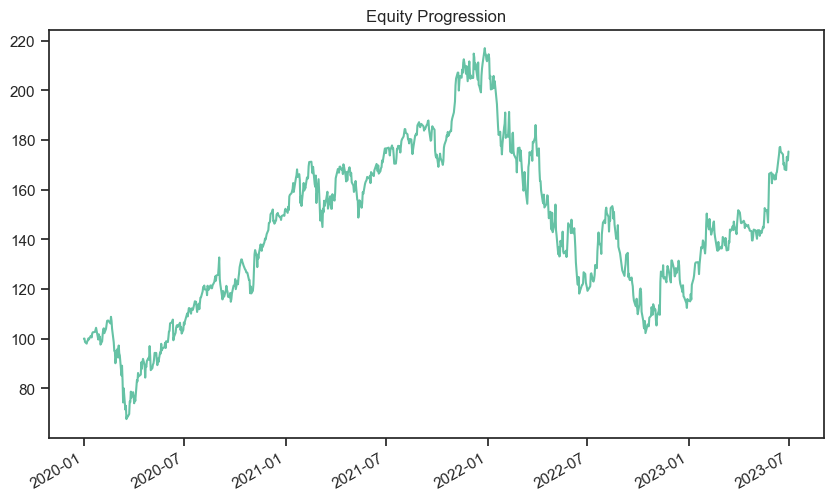

In [16]:
# 누적수익률 그래프

import matplotlib.pyplot as plt
%matplotlib inline

result.plot(figsize=(10, 6), legend=False)
plt.show()

In [17]:
# 종목별 투자비중
result.get_security_weights().head()

,spy,qqq,soxl,tlt
2020-01-01,0.000000,0.000000,0.000000,0.000000
2020-01-02,0.249896,0.249832,0.249994,0.249964
2020-01-03,0.251483,0.251017,0.239808,0.257374
2020-01-06,0.254092,0.254284,0.233719,0.257585
2020-01-07,0.250860,0.251723,0.243329,0.253772


1. area()를 통해 면적 그래프를 나타내며, 
2. 축의 범위는 0에서 1, 범례(legend)는 제외, 색 구분은 cm.jet을 이용한다.
3. get_legend_handles_labels()를 통해 범례를 받아온다.
4. 좌우 마진을 0으로 둔다.
5. legend() 함수를 통해 범례를 나타내며, 그래프와 색 순서를 맞추기 위해 reversed()를 통해 순서를 바꾼다. 또한 위치는 오른쪽 아래(lower right)의 (1.15, 0) 지점으로 한다.
6. 그림을 나타낸다.
- 매월 말 리밸런싱을 하므로, 대부분의 구간에서 모든 자산에 10%씩 균등하게 투자된다. 이번에는 각종 성과지표를 확인해보도록 하자.

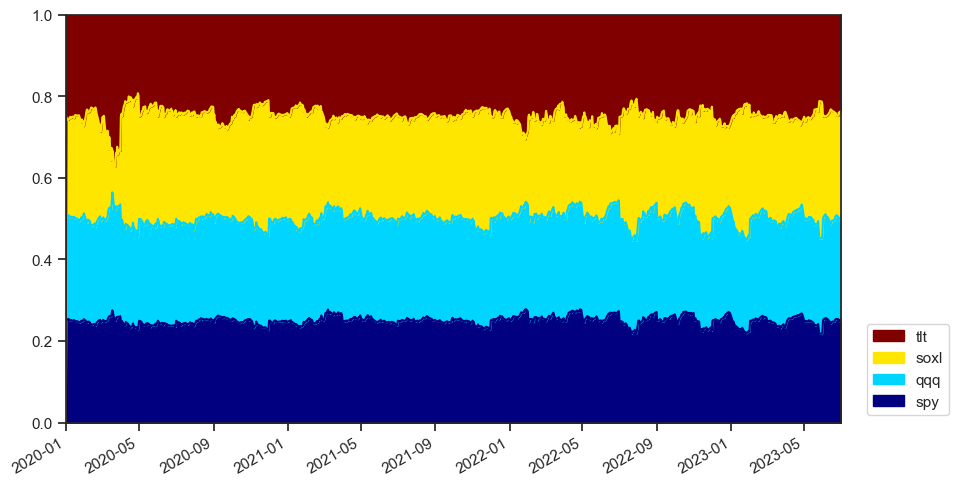

In [18]:
from matplotlib import cm

ax = result.get_security_weights().plot.area(figsize=(10, 6),
                                             ylim=[0, 1],
                                             legend=False,
                                             colormap=cm.jet)
handles, labels = ax.get_legend_handles_labels()
plt.margins(0, 0)
plt.legend(reversed(handles),
           reversed(labels),
           loc='lower right',
           bbox_to_anchor=(1.15, 0))
plt.show()

### display() 메서드를 통해 각종 성과 측정치를 구할 수 있다. 각 지표가 의미하는 바는 다음과 같다.
- Start; 시작일
- End: 종료일
- Risk-free rate: 무위험 수익률
- Total Return: 총 수익률
- Sharpe: 샤프지수 (평균 수익률/변동성)
- Sortino: 소티노지수 (평균 수익률/마이너스 수익률의 변동성)
- CAGR: 연평균 수익률
- Max drawdown: 최대 손실률 (MDD)
- Calmar Ratio: 칼마지수 (수익률/MDD)
- MTD / 3m / 6m / YTD: 금월, 3개월, 6개월, 올해 수익률
- 1Y / 3Y (ann.) / 5Y (ann.) / 10Y (ann.): 1년 / 3년 / 5년 / 10년 기준 연율화 수익률
- Since Incep. (ann): 시작 이후 연율화 수익률
- Mean (ann.): 연평균 수익률
- Vol (ann.): 연평균 변동성
- Skew: 왜도
- Kurt: 첨도
- Best: 최고 수익률
- Worst: 최저 수익률
- Avg. Drawdown: 손실(Drawdown)의 평균
- Avg. Drawdown Days: 손실(Drawdown) 발생 후 회복까지 평균일수
- Avg. Up Month: 상승한 달의 평균 수익률
- Avg. Down Month: 하락한 달의 평균 수익률
- Win Year %: 연도별 양의 수익률을 기록할 확률
- Win 12m %: 12개월 투자했을 시 양의 수익률을 기록할 확률

In [10]:
result.display()

Stat                 Asset_EW
-------------------  ----------
Start                2020-01-01
End                  2023-06-30
Risk-free rate       0.00%

Total Return         75.37%
Daily Sharpe         0.61
Daily Sortino        1.01
CAGR                 17.44%
Max Drawdown         -52.90%
Calmar Ratio         0.33

MTD                  7.87%
3m                   17.49%
6m                   51.84%
YTD                  51.84%
1Y                   45.45%
3Y (ann.)            18.11%
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  17.44%

Daily Sharpe         0.61
Daily Sortino        1.01
Daily Mean (ann.)    23.67%
Daily Vol (ann.)     38.90%
Daily Skew           -0.13
Daily Kurt           2.07
Best Day             12.07%
Worst Day            -10.77%

Monthly Sharpe       0.65
Monthly Sortino      1.21
Monthly Mean (ann.)  23.88%
Monthly Vol (ann.)   36.87%
Monthly Skew         -0.06
Monthly Kurt         -0.36
Best Month           21.69%
Worst Month          -19.00%

Y

C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\lib\site-packages\future\utils\__init__.py:315: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  return func(**kwargs)
C:\Users\com\anaconda3\li

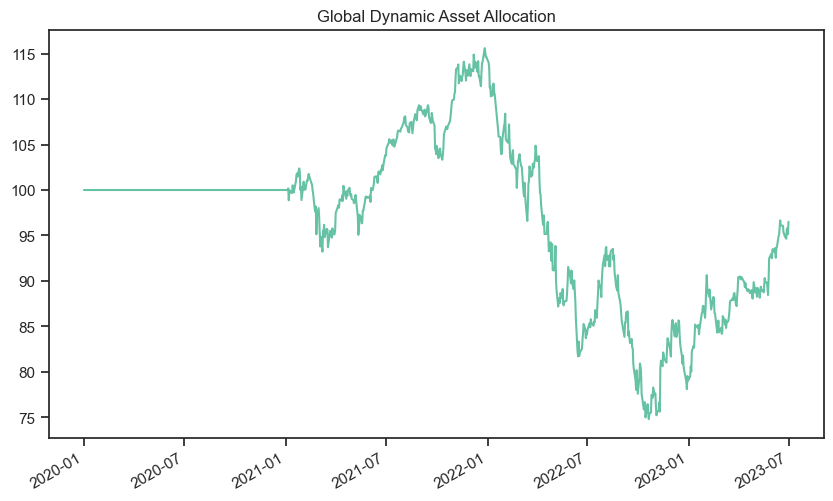

In [20]:
import bt
import matplotlib.pyplot as plt
import pandas as pd

data = data_bt

gdaa = bt.Strategy('GDAA', [
    bt.algos.SelectAll(),
    bt.algos.SelectMomentum(n=5, lookback=pd.DateOffset(years=1)),
    bt.algos.WeighERC(lookback=pd.DateOffset(years=1)),
    bt.algos.RunMonthly(),    
    bt.algos.Rebalance()
])

gdaa_backtest = bt.Backtest(gdaa, data_bt)
gdaa_result = bt.run(gdaa_backtest)

gdaa_result.plot(figsize=(10, 6),
                 title='Global Dynamic Asset Allocation',
                 legend=False)
plt.show()

In [23]:
gdaa_result.get_security_weights().head()

,soxl,qqq,spy,tlt
2020-01-01,0.0,0.0,0.0,0.0
2020-01-02,0.0,0.0,0.0,0.0
2020-01-03,0.0,0.0,0.0,0.0
2020-01-06,0.0,0.0,0.0,0.0
2020-01-07,0.0,0.0,0.0,0.0
